In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-attack-analysis-prediction-dataset/o2Saturation.csv
/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv


In [2]:
cd "/kaggle"

/kaggle


In [3]:
#loading the dataset
file_path = "input/heart-attack-analysis-prediction-dataset/heart.csv"
heart_data = pd.read_csv(file_path)
heart_data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


<AxesSubplot:>

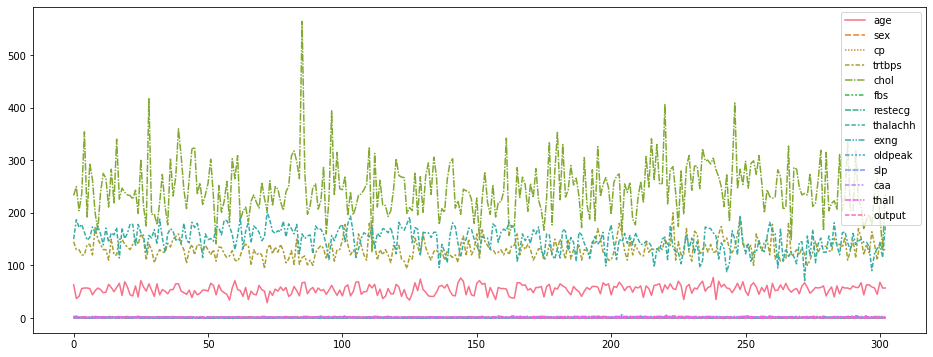

In [4]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Set the width and height of the figure
plt.figure(figsize=(16,6))

sns.lineplot(data=heart_data)

This line plot of the all the parameters does not provide a good insight. Lets take a look at the heat map below for a better insight into the data.

Text(0.5, 159.0, 'Various factors')

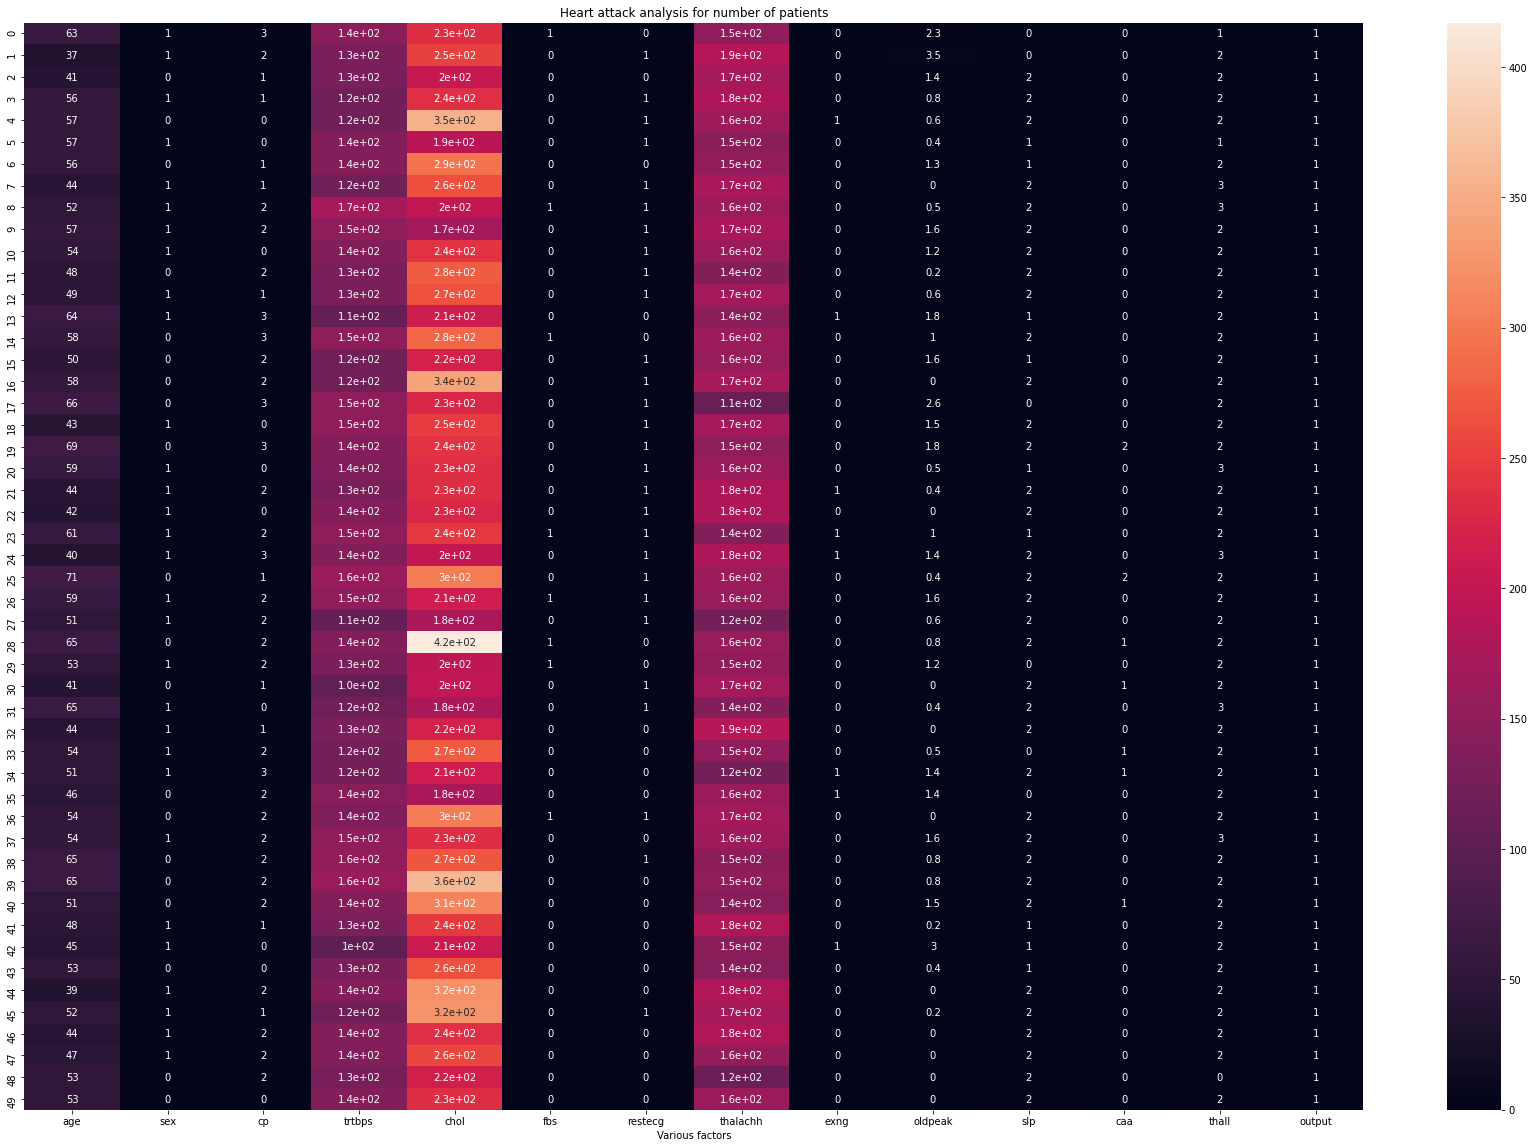

In [5]:
#creating a heatmap of cholestrol 
plt.figure(figsize=(30,20))
plt.title("Heart attack analysis for number of patients")
sns.heatmap(data=heart_data[:50], annot=True)

plt.xlabel("Various factors")



The heatmap above is of first 50 rows , but it does tells us a story. It seems there is a correlation between age , cholestrol , resting blood pressure and highest blood pressure. We will strengthen this point using a correlation plot.

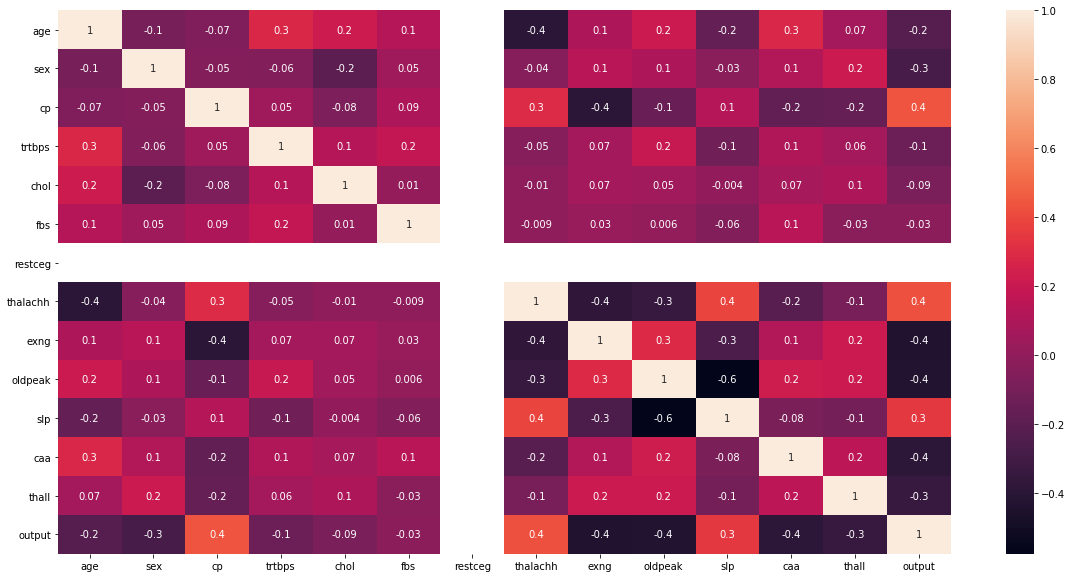

In [6]:
import pandas as pd
df= pd.DataFrame(heart_data,columns=["age","sex","cp","trtbps","chol","fbs","restceg","thalachh","exng","oldpeak","slp","caa","thall","output"])
corrMatrix= df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corrMatrix, annot= True,fmt='.1g')

plt.show()

* This correlation heatmap definitely provides, very good insight into the data.Cholestrol, Resting blood pressure and oldpeak have positive correlation with age.
* There are no two columns whose values are highly correlated , so we have to keep all the columns as they are contributing to the final output independently.
* The heart rate output is closely correlated with cp, thalachh and slp. We will be plotting scatter plots to dive deep into this insight.

<AxesSubplot:xlabel='cp', ylabel='thalachh'>

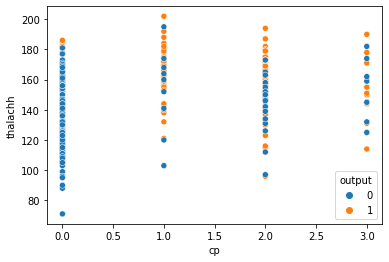

In [7]:
sns.scatterplot(x=heart_data['cp'], y=heart_data['thalachh'], hue=heart_data['output'])

Inference drawn from above scatter plot:
*  If the number of major vessels are less the chances of heart attack is less. It increases a bit with the number of major vessels.
*  As the value of maximum blood pressure is increased the heart attacks increases. basically if it is above 180 mm Hg.


<AxesSubplot:xlabel='output', ylabel='age'>

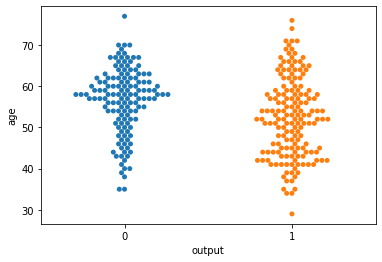

In [8]:
# lets do a swarm plot of age and cholestrol against the heart rate output.
sns.swarmplot(x=heart_data['output'],
              y=heart_data['age'])

It seems chances of heart rate are more in between the age of 40-55. It decreases above the age of 55.

<AxesSubplot:xlabel='output', ylabel='chol'>

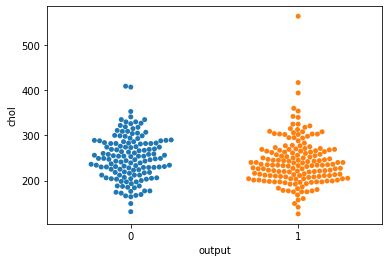

In [9]:
sns.swarmplot(x=heart_data['output'],
              y=heart_data['chol'])

<AxesSubplot:xlabel='age', ylabel='chol'>

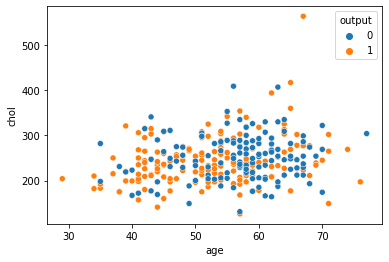

In [10]:
sns.scatterplot(x=heart_data['age'], y=heart_data['chol'], hue=heart_data['output'])

from the above scatter plot it is seems cholestrol in between 300- 200 mg/dl for the age of 40-55 is the perfect recipe for heart attack.

**Now we will do some preprocessing on the dataset**.

In [11]:
#Doing test train split
from sklearn.model_selection import train_test_split

#Selecting target
y=heart_data.output

#using only numerical predictors
heart_predictors= heart_data.drop(['output'],axis=1)
X = heart_predictors.select_dtypes(exclude=['object'])

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [12]:
#We make a score dataset function to check the correctness of different approach
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

In [13]:
# Get names of columns with missing values
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]
print(cols_with_missing)
# Drop columns in training and validation data
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

print("MAE from Approach 1 (Drop columns with missing values):")
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))

[]
MAE from Approach 1 (Drop columns with missing values):
0.20655737704918034


There are no missing values in this dataset. So handling of missing values is not required.

In [14]:
#Performing prediction using XGBoost
from sklearn import metrics
from xgboost import XGBClassifier
#Initialize the classifier
clf= XGBClassifier()
clf.fit(reduced_X_train,y_train)
predictions =clf.predict(reduced_X_valid)
metrics.accuracy_score(y_valid,predictions)


[06:29:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7868852459016393

Accuracy achieved is 78.68% . Its a decent accuracy but it definitely can be improved.Lets try GridSearchCV to imporve the accuracy.

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from xgboost import XGBClassifier

#Initialize the classifier
clf= XGBClassifier()

#Parameters
parameters =  {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5], #number of trees, change it to 1000 for better results
              'missing':[-999],
               'seed': [1337]}



scorer = make_scorer(fbeta_score,beta=0.5)

grid_obj = GridSearchCV(clf, parameters,scorer)

grid_fit = grid_obj.fit(reduced_X_train,y_train)

[06:29:59] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[06:29:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:29:59] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[06:29:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation me

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass scoring=make_scorer(fbeta_score, beta=0.5) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when

In [16]:
# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using unoptimized and optimized model
predictions = (clf.fit(reduced_X_train, y_train)).predict(X_valid)
best_predictions = best_clf.predict(X_valid)

[06:29:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [17]:
from sklearn.metrics import accuracy_score
# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on validation data: {:.4f}".format(accuracy_score(y_valid, predictions)))
print("F-score on validation data: {:.4f}".format(fbeta_score(y_valid, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the validation data: {:.4f}".format(accuracy_score(y_valid, best_predictions)))
print("Final F-score on the validation data: {:.4f}".format(fbeta_score(y_valid, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on validation data: 0.7869
F-score on validation data: 0.8133

Optimized Model
------
Final accuracy score on the validation data: 0.8689
Final F-score on the validation data: 0.8708


So, using GridSearCV definitely increases the accuracy of XGboost classifier from 0.7869 to 0.8689

In [18]:
#implementing random forset classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
model_rf= RandomForestClassifier()
model_rf.fit(reduced_X_train,y_train)
# Make predictions for the test set
y_pred_rf = model_rf.predict(reduced_X_valid)
# View accuracy score
metrics.accuracy_score(y_valid, y_pred_rf)


0.8688524590163934

In [19]:
#checking the accuracy using logistic regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=50).fit(reduced_X_train, y_train)
y_pred_lr=clf.predict(reduced_X_valid)
metrics.accuracy_score(y_valid, y_pred_rf)


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8688524590163934